<h1>Decision Trees</h1>

<p>Decision Trees are, like SVMs, among the main algorithms in Machine Learning because of their versatility. Indeed, they can be used for both classification and regression and even multioutput tasks. Furthermore, they are the pillars of Random Forest, one of the most powerful Machine Learning algorithm.</p>

<b>How they work?</b>
<p><i>http://scikit-learn.org/stable/modules/tree.html</i></p>
<img src="img/iris.png" width="800" height="900"></img>

<p>As you can see, Decision Trees are very easy to understand: you start at the root node and then you move down, left or right, according to the condition, until you reach one prediction.</p>

<b>What's Gini's score?</b>
<p>It measures the impurity of the nodes: a node is pure (gini=0) if all training instances it applies to belong to the same class.</p>
<img src="img/gini.png"></img>
<p>An alternative to the Gini impurity is the <b>Entropy</b> impurity (search it for more information).</p>
<img src="img/entropy.png"></img>
<p>In general, both lead to similar trees, so you can use the default one (Gini)</p>

<h3>Notes about DTs:</h3>
- Computational complexity?
  <b>O(n x mlog(m))</b>
- <b>Nonparametric</b> model (pay attention to overfitting)
- Scikit uses the <b>CART algorithm</b> by default
- <b>Don't<b> require scaling
- Sensitive to training set <b>rotation</b>

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn import datasets
from sklearn.model_selection import train_test_split

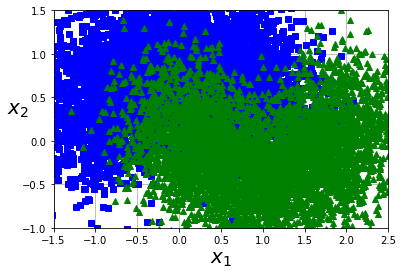

In [2]:
# Import the dataset
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Let's search good hyperparameter values
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

param_grid = [
    {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
]

dec_tree_clf = DecisionTreeClassifier()
grid_search = GridSearchCV(dec_tree_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'min_samples_split': [2, 3, 4], 'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [5]:
grid_search.best_params_

{'max_leaf_nodes': 23, 'min_samples_split': 2}

In [6]:
grid_search.best_score_

0.85924999999999996

In [7]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.87350000000000005

In [8]:
# Cool! Now let's build a forest, dividing our decision tree in 1000 subsets
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

In [9]:
# We can now apply the previous hyperparameters to these subsets
from sklearn.base import clone

forest = [clone(grid_search.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = tree.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.79857849999999997

<h4>Of course the mean is smaller than the accuracy score we calculated before because we trained our small trees on much less data. BUT now we can mix all the trees' results and with the <i>mode</i> function we can get the majority vote prediction:</h4>

In [10]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)
    
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.872